## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Import libraries

In [1]:
#Adding required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import cv2
import glob # To read all images inside a folder
import yaml
%matplotlib inline
from matplotlib import rcParams
# figure size in inches optional
rcParams['figure.figsize'] = 20 ,10


## Function implementation for Camera Calibration

In [2]:

# Flag for debugging the output
DEBUG_ENABLED = 0    
CALIBRATE = 1 
# Write real world co-ordinates of the corners of the chess board.    
objp = np.zeros(((9*6),3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
     
# Lists for holding objects points and their image coordinates
imgpoints = []
objpoints = []

# This function return Grayscale image
def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# This function draws corners of the chess board on the color input image
def draw_chess_board_corners(ret, corners, img, objpoints, imgpoints):
    if (ret == True):
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        objpoints.append(objp)
        imgpoints.append(corners)
        if(DEBUG_ENABLED):
            plt.imshow(img, cmap ='gray')
            plt.title("ChessBoard Corner Image")
            plt.show()
        return objpoints, imgpoints

# This function calculates Camera matrix and Distortion coeffients 
def calibrate_camera(images):    
    for image in images:
        img = plt_img.imread(image)
        gray = grayscale(img)
        if(0):
            plt.imshow(gray, cmap ='gray')
            plt.title("Grayscale image")
            plt.show()
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)    
        draw_chess_board_corners(ret, corners, img, objpoints, imgpoints)            
    #Calibrate camera     
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Returns Camera matrix (mtx) and Distortion coeffients (dist)
    return mtx, dist

def undistort_chessboard_images(images, mtx, dist):
    list_undistrted_images = []
    for image in images:
        img = plt_img.imread(image) 
        # Un-distort images
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        # Append all undistorted images and return
        list_undistrted_images.append(dst)
    return list_undistrted_images

def undistort_images(image, mtx, dist):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    if(0):
        plt.imshow(dst)
        plt.title("ChessBoard Corner Image")
        plt.show()
    return dst

def draw_results(list_undistorted_images):
    plt.figure(figsize=(20,10))
    plt.title("Undistorted Chessboard Images")
    columns = 5
    for i, image in enumerate(list_undistorted_images):
        plt.subplot(len(list_undistorted_images) / columns + 1, columns, i + 1)        
        plt.imshow(image)
    

## Run the following code to see the results of undistorted chessboard.

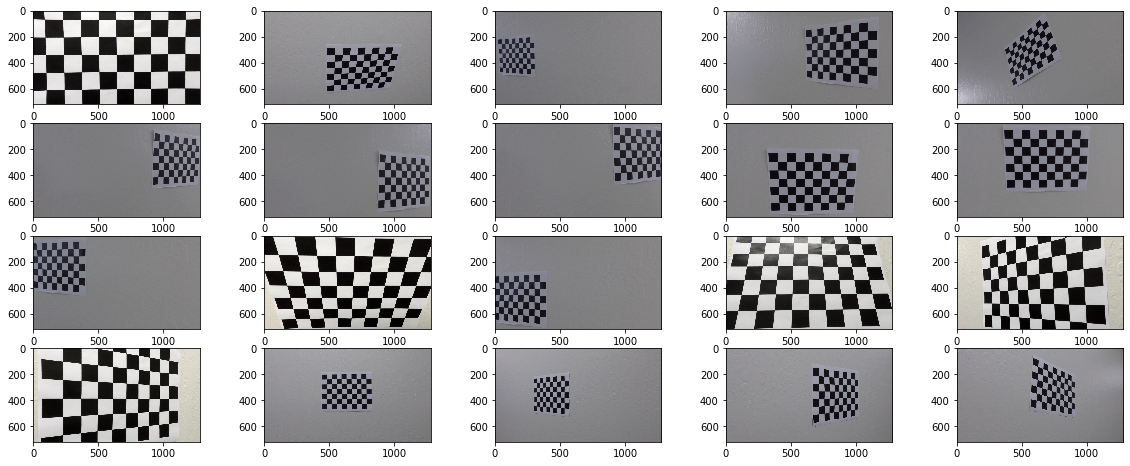

In [3]:
# Read all images from a folder
images = glob.glob("camera_cal/*.jpg")

# Calibrate Camera
mtx, dist = calibrate_camera(images)   
        
# Undistort Chess Images
list_undistorted_images = undistort_chessboard_images(images, mtx, dist)

# Draw Results 
draw_results(list_undistorted_images)
  

## Function implementation for Binary image creation
Use color transforms, gradients, etc., to create a thresholded binary image.

In [4]:
# Edit this function to create your own pipeline.
def binary_image_creation(img, sx_thresh=(20, 100), s_thresh=(170, 255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

## Run the following code to see a binary image

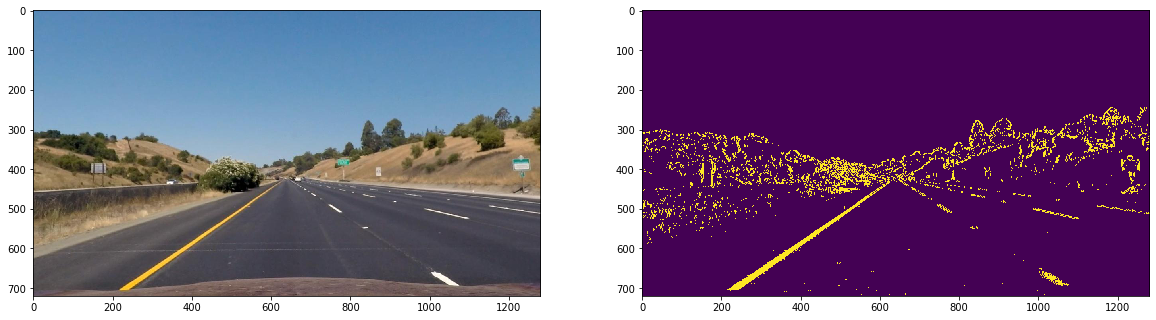

In [5]:
undistorted_image = plt_img.imread("examples/undistorted_image.jpg")
    
# Binary image creation
binay_image = binary_image_creation(undistorted_image, sx_thresh=(20, 100), s_thresh=(170, 255))

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(undistorted_image);
ax[1].imshow(binay_image);

## Function implementation for Perspective Transform ("birds-eye view").

In [6]:
 def perspective_transform(src, dst, undist_image):
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    img_size = (undist_image.shape[1], undist_image.shape[0])
    warped = cv2.warpPerspective(undist_image, M, img_size)
    return warped    

## Run the following code to see Bird-Eye View

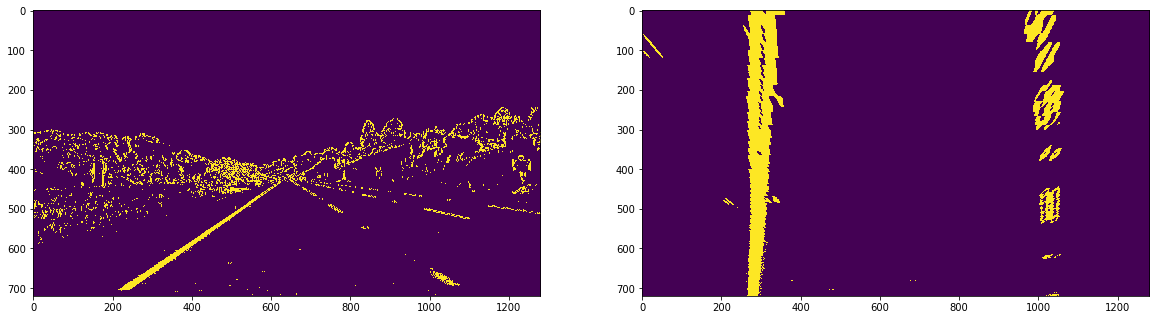

In [7]:
# Undistort Test Images
undistorted_image = plt_img.imread("examples/undistorted_image.jpg")

# Binary image creation
binay_image = binary_image_creation(undistorted_image, sx_thresh=(20, 100), s_thresh=(170, 255))

# Pixel points on the road in the input image
src = np.float32([[260, 670], [590, 450], [690, 450], [1041, 670]])

# Points where the input image is to be transformed
dst = np.float32([[260, 719], [260, 0], [1050, 0], [1050, 719]])

# # Perspective Transformation  
binary_warped = perspective_transform(src, dst, binay_image) 

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(binay_image);
ax[1].imshow(binary_warped);


## Function implemenation for detecting lane pixels and fitting the lane boundary.

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin # Update this        
        
        # Draw the windows on the visualization image        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&
        (nonzerox >= win_xleft_low)&(nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds =((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&
        (nonzerox >= win_xright_low)&(nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print("left_fit =", left_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #print("left_fitx =", left_fitx)
        #print("ploty =", ploty)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fit, right_fit 

## Run the following code to lines fitting the lanes

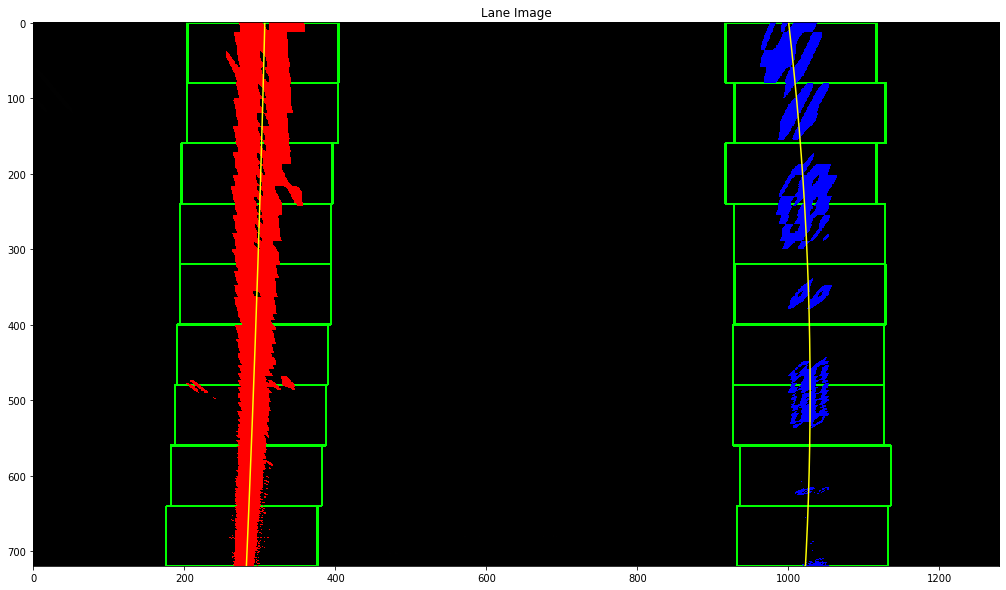

In [9]:
# Undistort Test Images
undistorted_image = plt_img.imread("examples/undistorted_image.jpg")

# Binary image creation
binay_image = binary_image_creation(undistorted_image, sx_thresh=(20, 100), s_thresh=(170, 255))

# Pixel points on the road in the input image
src = np.float32([[260, 670], [590, 450], [690, 450], [1041, 670]])    
# Points where the input image is to be transformed
dst = np.float32([[260, 719], [260, 0], [1050, 0], [1050, 719]])

# # Perspective Transformation  
binary_warped = perspective_transform(src, dst, binay_image)

# Detect lane pixels and fit to find the lane boundary.
out_img, left_fit, right_fit = fit_polynomial(binary_warped)

# display images
plt.imshow(out_img)
plt.title("Lane Image")
plt.show()

## Function implementation for skipping the sliding windows step

In [10]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
  
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###   
    
    left_lane_inds = ((nonzerox >(left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
    left_fit[2] - margin)) & ((nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
    left_fit[2]) + margin)) )
    
    right_lane_inds = ((nonzerox >(right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
    right_fit[2] - margin)) & ((nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
    right_fit[2]) + margin)) )

    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
  
    
    return result

## Run the code below to see the results 

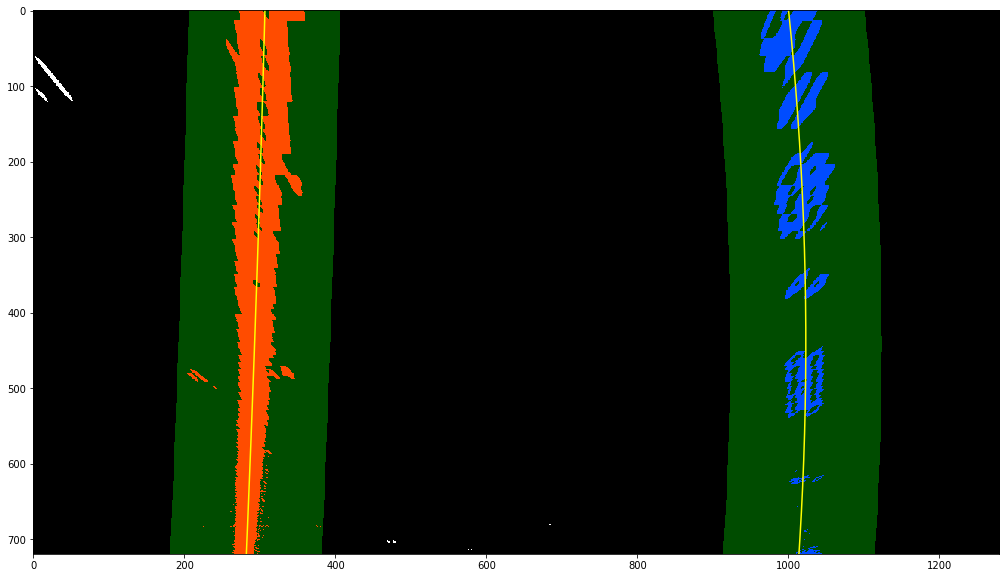

In [11]:
# Undistort Test Images
undistorted_image = plt_img.imread("examples/undistorted_image.jpg")

# Binary image creation
binay_image = binary_image_creation(undistorted_image, sx_thresh=(20, 100), s_thresh=(170, 255))

# Pixel points on the road in the input image
src = np.float32([[260, 670], [590, 450], [690, 450], [1050, 670]])
# Points where the input image is to be transformed
dst = np.float32([[260, 719], [260, 0], [1050, 0], [1050, 719]])

# # Perspective Transformation  
binary_warped = perspective_transform(src, dst, binay_image) 

left_fit = [-5.79451128e-06, -3.29676456e-02,  3.08629541e+02]
right_fit = [-1.24089778e-04,  1.21733361e-01,  9.98608657e+02]

result = search_around_poly(binary_warped, left_fit, right_fit)
plt.imshow(result)

## Function implementation for determining the curvature of the lane and vehicle position with respect to center.

Equation of a second order polynomial curve

\begin{equation*}
  f (y) = A y ^2 + By + C 
\end{equation*}

Radius of Curvature
[Reference](https://www.intmath.com/applications-differentiation/8-radius-curvature.php) 
\begin{equation*}
  R_{curve} = \frac{(1+( \frac{\partial y}{\partial x})^2)^3/2}{\frac {d^{2}y}{dx^{2}}} 
\end{equation*}

Using the above formula for the equation of second order polynomial curve

\begin{equation*}
  R_{curve} = \frac{(1+(2Ay+B)^2)^3/2}{2A} 
\end{equation*}



In [15]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    
    return left_curverad, right_curverad

## Run the code below to calculate radius of curvature in pixels

In [14]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
left_fit = [-5.79451128e-06, -3.29676456e-02,  3.08629541e+02]
right_fit = [-1.24089778e-04,  1.21733361e-01,  9.98608657e+02]
measure_curvature_pixels(ploty, left_fit, right_fit)

(86509.42212486186, 4048.792510063248)

## Start point of the pipeline

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

2. Use color transforms, gradients, etc., to create a thresholded binary image.

3. Apply a perspective transform to rectify binary image ("birds-eye view").

4. Detect lane pixels and fit to find the lane boundary.

5. Determine the curvature of the lane and vehicle position with respect to center.

6. Warp the detected lane boundaries back onto the original image.

7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

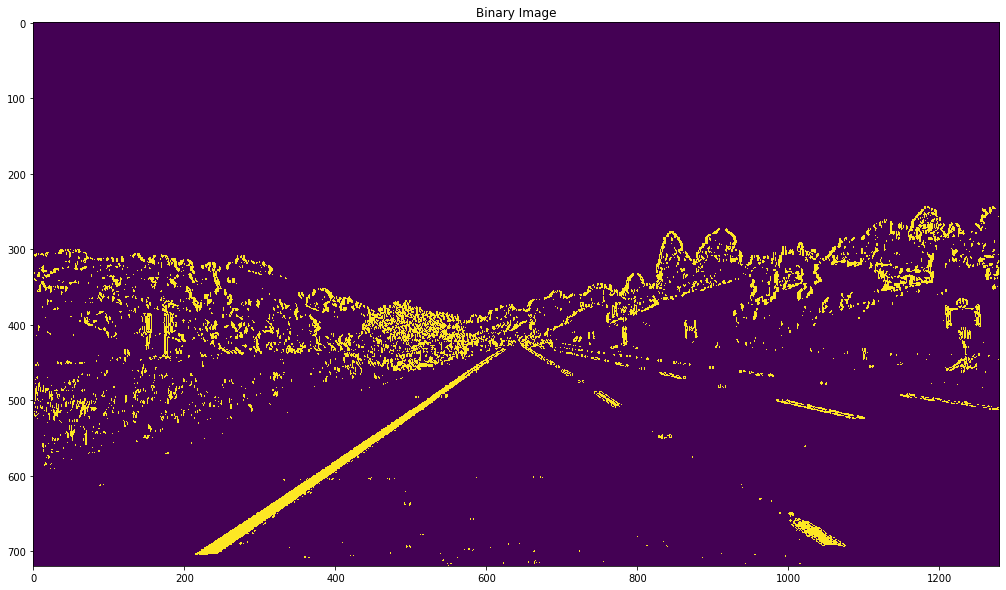

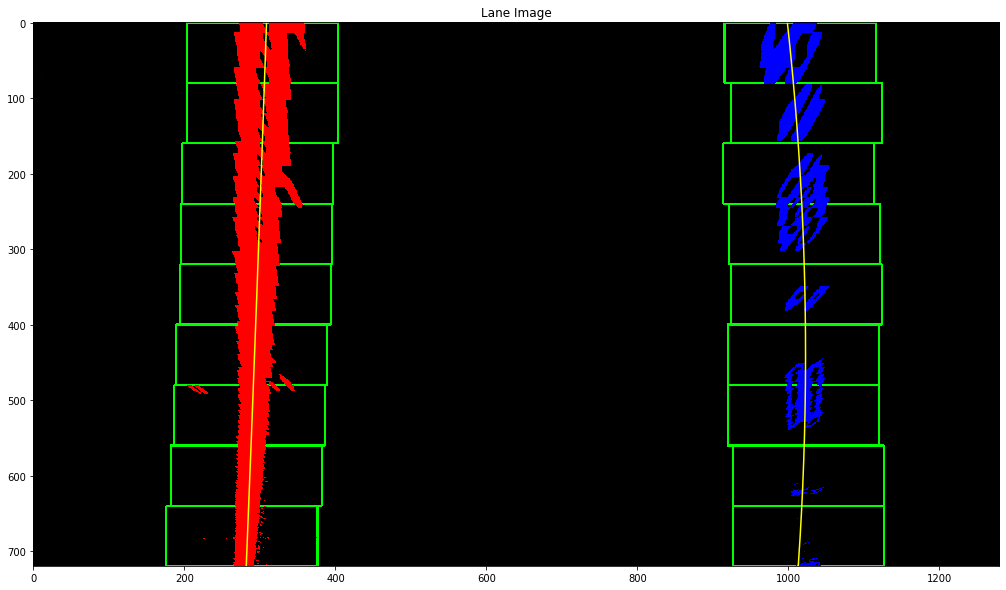

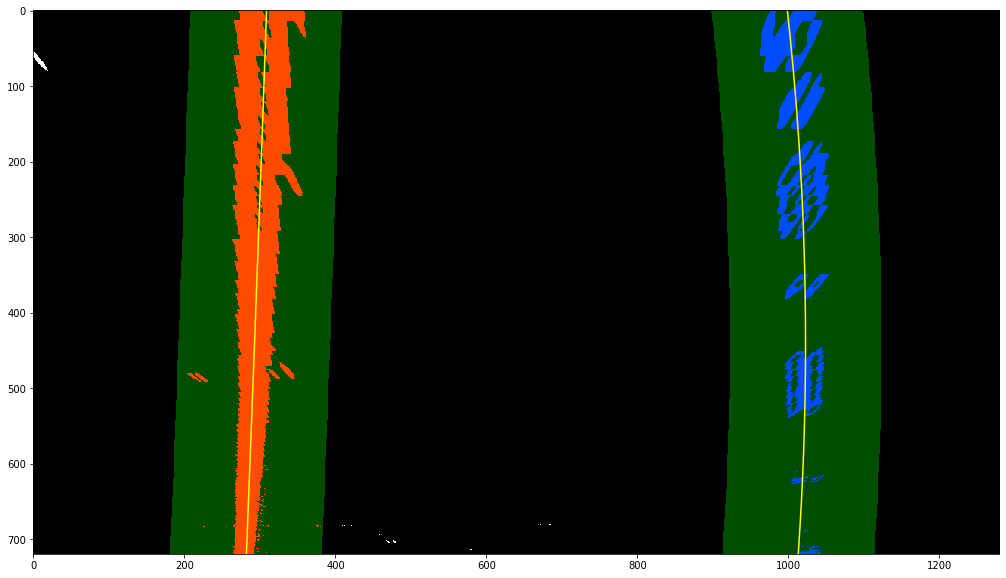

In [12]:
        
if (__name__== '__main__' ): 
    
    # Undistort Test Images
    image = plt_img.imread("test_images/straight_lines1.jpg")
    undistorted_image = undistort_images(image, mtx, dist)
    
    # Binary image creation
    binay_image = binary_image_creation(undistorted_image, sx_thresh=(20, 100), s_thresh=(170, 255))
    if(1):
        plt.imshow(binay_image)
        plt.title("Binary Image")
        plt.show()        
    
    # Pixel points on the road in the input image
    src = np.float32([[260, 670], [590, 450], [690, 450], [1050, 670]])
    # Points where the input image is to be transformed
    dst = np.float32([[260, 719], [260, 0], [1050, 0], [1050, 719]])
    
    # # Perspective Transformation  
    binary_warped = perspective_transform(src, dst, binay_image)    
    
    # Detect lane pixels and fit to find the lane boundary.
    out_img, left_fit, right_fit = fit_polynomial(binary_warped)   
    if(1):
        plt.imshow(out_img)
        plt.title("Lane Image")
        plt.show() 
    # Logic to find region of interest from second frame onwards
    result = search_around_poly(binary_warped, left_fit, right_fit)
    plt.imshow(result)